In [1]:
import sys
sys.path.insert(0, "/media/allen/mass/SPOS-pytorch/")
import json

In [44]:
spos_search = []
for i in range(20):
    with open(f"/media/allen/mass/spos_search/spos_search_history_{i:03}.json", 'r') as f:
        spos_search.append(json.load(f))
    

In [3]:
accs = [float(acc) for acc in list(spos_search[0].keys())]

In [57]:
result

{'block': [3, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 0, 3, 3, 0, 3],
 'channel': [8, 9, 1, 2, 9, 8, 7, 7, 6, 6, 9, 3, 3, 2, 7, 1],
 'flops': 78.854279,
 'param': 1.165887,
 'error': 0.4140791893005371}

In [60]:
spos_table = []
for history in spos_search:
    for acc in history:
        for result in history[acc]:
            spos_table.append((float(acc), result['flops'], result['block'], result['channel'], result['error']))

In [61]:
spos_table[9577]

(0.583,
 68.693639,
 [3, 0, 3, 0, 0, 3, 3, 0, 3, 0, 3, 0, 3, 0, 0, 3],
 [8, 1, 5, 0, 1, 8, 5, 6, 6, 6, 3, 8, 3, 8, 1, 1],
 0.4167083501815796)

In [56]:
for i in range(len(spos_table)):
    if spos_table[i] == tuple(candidate):
        print(i)

9577
10529


In [47]:
import numpy as np
spos_data = np.array(list(set(spos_table)))

In [31]:
import seaborn as sns

In [39]:
spos_data.sort(axis=0)

In [53]:
candidate = spos_data[np.argsort(spos_data[:,0])][-100:][-4]

Text(0.5, 1.0, 'Search History')

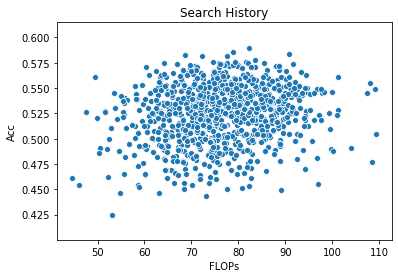

In [62]:
ax = sns.scatterplot(x=spos_data[:,1], y=spos_data[:,0])
ax.set_xlabel('FLOPs')
ax.set_ylabel('Acc')
ax.set_title('Search History')

Text(0.5, 1.0, 'Search History - Top 100')

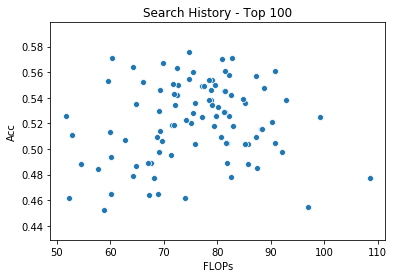

In [63]:
ax = sns.scatterplot(x=spos_data[-100:,1], y=spos_data[-100:,0])
ax.set_xlabel('FLOPs')
ax.set_ylabel('Acc')
ax.set_title('Search History - Top 100')

In [2]:
import torch
from src.model.backbone.shufflenas import shufflenas_oneshot
from tools.spos_utils import Darwin

ModuleNotFoundError: No module named 'tools'

In [4]:
model = shufflenas_oneshot(
    input_size=112, 
    n_class=10,
    use_se=True,
    last_conv_after_pooling=True,
    channels_layout='OneShot')

In [5]:
all_channel_mask, all_channel_choice = model.random_channel_mask(epoch_after_cs=-1)
all_block_choice = model.random_block_choices()

In [6]:
x = torch.rand(2,3,224,224).cuda()
all_channel_mask = all_channel_mask.cuda()
model = model.cuda()
model.eval()
with torch.no_grad():
    model(x, all_block_choice, all_channel_mask)

In [9]:
model = torch.nn.DataParallel(model)

In [10]:
p = next(iter(model.parameters()))
p.is_cuda

True

In [1]:
import sys
sys.path.insert(0, "/media/allen/mass/SPOS-pytorch/")
import torch
import torch.nn as nn
from src.model.module.spos_modules import *
from src.model.module.base_module import *
from thop import profile

In [2]:
def count_hs(m, x, y):
    x = x[0]

    nelements = x.numel()

    m.total_ops += torch.Tensor([int(nelements * 2)])

In [18]:

input_size=224
n_class=1000
use_se=True
last_conv_after_pooling=True
last_conv_out_channel=1024
channels_layout = 'OneShot'
stage_repeats = [4, 4, 8, 4]
stage_out_channels = [64, 160, 320, 640]
channel_scales = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0] 
block_choices = [0, 1, 2, 3]

input_channel = 16
last_conv_after_pooling = last_conv_after_pooling
lookup_table = dict()
lookup_table['config'] = dict()
lookup_table['config']['use_se'] = use_se
lookup_table['config']['last_conv_after_pooling'] = last_conv_after_pooling
lookup_table['config']['channels_layout'] = channels_layout
lookup_table['config']['stage_repeats'] = stage_repeats
lookup_table['config']['stage_out_channels'] = stage_out_channels
lookup_table['config']['channel_scales'] = channel_scales
lookup_table['config']['first_conv_out_channel'] = input_channel
lookup_table['config']['input_size'] = input_size
lookup_table['config']['last_conv_out_channel'] = last_conv_out_channel
lookup_table['flops'] = dict()
lookup_table['params'] = dict()

In [19]:
inp = torch.rand(1,3,224,224)
input_block = nn.Sequential(            
    nn.Conv2d(
        in_channels=3, 
        out_channels=input_channel, 
        kernel_size=3, 
        stride=2,
        padding=1, 
        bias=False),
    nn.BatchNorm2d(input_channel, affine=False),
    HardSwish()
  )
input_block_flops, input_block_params = profile(input_block, inputs=(inp,), custom_ops={HardSwish:count_hs})
input_block.eval()
inp = input_block(inp)
lookup_table['flops']['input_block'] = input_block_flops
lookup_table['params']['input_block'] = input_block_params

In [20]:
lookup_table['flops']['nas_block'] = {}
lookup_table['params']['nas_block'] = {}

block_idx = 0
global_max_length = make_divisible(int(stage_out_channels[-1] // 2 * channel_scales[-1]))
for stage_id in range(len(stage_repeats)):
    numrepeat = stage_repeats[stage_id]
    output_channel = stage_out_channels[stage_id]

    if use_se:
        act_name = 'hard_swish' if stage_id >= 1 else 'relu'
        block_use_se = True if stage_id >= 2 else False
    else:
        act_name = 'relu'
        block_use_se = False
    # create repeated blocks for current stage
    for i in range(numrepeat):
        stride = 2 if i == 0 else 1
        for block_choice in block_choices:
            for channel_choice, scale in enumerate(channel_scales):     
                local_mask = [0] * global_max_length
                mid_channel = make_divisible(int(output_channel // 2 * scale))
                for j in range(mid_channel):
                    local_mask[j] = 1
                    local_mask = torch.Tensor(local_mask)
                # SNB 3x3
                if block_choice == 0:
                    block = ShuffleNetCSBlock(
                        input_channel, output_channel, mid_channel,
                        3, stride, 'ShuffleNetV2', act_name=act_name, use_se=block_use_se)
                if block_choice == 1:
                    block = ShuffleNetCSBlock(
                        input_channel, output_channel, mid_channel,
                        3, stride, 'ShuffleNetV2', act_name=act_name, use_se=block_use_se)
                if block_choice == 2:
                    block = ShuffleNetCSBlock(
                        input_channel, output_channel, mid_channel,
                        3, stride, 'ShuffleNetV2', act_name=act_name, use_se=block_use_se)
                if block_choice == 3:
                    block = ShuffleNetCSBlock(
                        input_channel, output_channel, mid_channel,
                        3, stride, 'ShuffleXception', act_name=act_name, use_se=block_use_se)
                # fill the table
                choice_id = (block_idx, block_choice, channel_choice)
                block_flops, block_params = profile(block, inputs=(inp, local_mask), custom_ops={HardSwish:count_hs})
                lookup_table['flops']['nas_block'][choice_id] = block_flops
                lookup_table['params']['nas_block'][choice_id] = block_params
        
                print(choice_id)
        if stride == 2:
            input_size //= 2
        block.eval()
        inp = block(inp, torch.ones(global_max_length))
        input_channel = output_channel
        block_idx += 1
            

(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 0, 3)
(0, 0, 4)
(0, 0, 5)
(0, 0, 6)
(0, 0, 7)
(0, 0, 8)
(0, 0, 9)
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 1, 5)
(0, 1, 6)
(0, 1, 7)
(0, 1, 8)
(0, 1, 9)
(0, 2, 0)
(0, 2, 1)
(0, 2, 2)
(0, 2, 3)
(0, 2, 4)
(0, 2, 5)
(0, 2, 6)
(0, 2, 7)
(0, 2, 8)
(0, 2, 9)
(0, 3, 0)
(0, 3, 1)
(0, 3, 2)
(0, 3, 3)
(0, 3, 4)
(0, 3, 5)
(0, 3, 6)
(0, 3, 7)
(0, 3, 8)
(0, 3, 9)
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 0, 3)
(1, 0, 4)
(1, 0, 5)
(1, 0, 6)
(1, 0, 7)
(1, 0, 8)
(1, 0, 9)
(1, 1, 0)
(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(1, 1, 4)
(1, 1, 5)
(1, 1, 6)
(1, 1, 7)
(1, 1, 8)
(1, 1, 9)
(1, 2, 0)
(1, 2, 1)
(1, 2, 2)
(1, 2, 3)
(1, 2, 4)
(1, 2, 5)
(1, 2, 6)
(1, 2, 7)
(1, 2, 8)
(1, 2, 9)
(1, 3, 0)
(1, 3, 1)
(1, 3, 2)
(1, 3, 3)
(1, 3, 4)
(1, 3, 5)
(1, 3, 6)
(1, 3, 7)
(1, 3, 8)
(1, 3, 9)
(2, 0, 0)
(2, 0, 1)
(2, 0, 2)
(2, 0, 3)
(2, 0, 4)
(2, 0, 5)
(2, 0, 6)
(2, 0, 7)
(2, 0, 8)
(2, 0, 9)
(2, 1, 0)
(2, 1, 1)
(2, 1, 2)
(2, 1, 3)
(2, 1, 4)
(2, 1, 5)
(2, 1, 6)
(2, 1, 7)
(2, 1, 8)
(2, 1, 9)


(19, 2, 7)
(19, 2, 8)
(19, 2, 9)
(19, 3, 0)
(19, 3, 1)
(19, 3, 2)
(19, 3, 3)
(19, 3, 4)
(19, 3, 5)
(19, 3, 6)
(19, 3, 7)
(19, 3, 8)
(19, 3, 9)


In [21]:
if last_conv_after_pooling:
    # MobileNet V3 approach
    output_block = [
        nn.AdaptiveAvgPool2d(1),
        # no last SE for MobileNet V3 style
        nn.Conv2d(input_channel, last_conv_out_channel, kernel_size=1, stride=1,
                    padding=0, bias=True),
        # No bn for the conv after pooling
        HardSwish()
    ]
else:
    if self.use_se:
        # ShuffleNetV2+ approach
        output_block = [
            nn.Conv2d(input_channel, make_divisible(last_conv_out_channel * 0.75), 
                        kernel_size=1, stride=1,
                        padding=0, bias=False),
            nn.BatchNorm2d(make_divisible(last_conv_out_channel * 0.75), affine=False),
            HardSwish(),
            nn.AdaptiveAvgPool2d(1),
            SEModule(make_divisible(last_conv_out_channel * 0.75)),
            nn.Conv2d(last_conv_out_channel, make_divisible(last_conv_out_channel * 0.75), 
                        kernel_size=1, stride=1,
                        padding=0, bias=True),
            # No bn for the conv after pooling
            HardSwish()
        ]
    else:
        # original Oneshot Nas approach
        output_block = [
            nn.Conv2d(input_channel, last_conv_out_channel, 
                        kernel_size=1, stride=1,
                        padding=0, bias=False),
            nn.BatchNorm2d(last_conv_out_channel, affine=False),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        ]
        
output_block.append(nn.Dropout(0.2 if use_se else 0.1))
output_block.append(nn.Conv2d(last_conv_out_channel, n_class, 
                kernel_size=1, stride=1,
                padding=0, bias=True),
            )
output_block = nn.Sequential(*output_block)

output_block_flops, output_block_params = profile(output_block, inputs=(inp,), custom_ops={HardSwish:count_hs})
output_block.eval()
inp = output_block(inp)
lookup_table['flops']['output_block'] = output_block_flops
lookup_table['params']['output_block'] = output_block_params

In [55]:
all_channel_choice = np.array(all_channel_choice)
all_channel_choice = 0
all_channel_choice

0

In [29]:
all_block_choice.numpy()[0]

2

In [25]:
lookup_table['flops']

{'input_block': 6221824.0,
 'nas_block': {(0, 0, 0): 5042688.0,
  (0, 0, 1): 8329216.0,
  (0, 0, 2): 11615744.0,
  (0, 0, 3): 14902272.0,
  (0, 0, 4): 14902272.0,
  (0, 0, 5): 18188800.0,
  (0, 0, 6): 21475328.0,
  (0, 0, 7): 24761856.0,
  (0, 0, 8): 28048384.0,
  (0, 0, 9): 28048384.0,
  (0, 1, 0): 5042688.0,
  (0, 1, 1): 8329216.0,
  (0, 1, 2): 11615744.0,
  (0, 1, 3): 14902272.0,
  (0, 1, 4): 14902272.0,
  (0, 1, 5): 18188800.0,
  (0, 1, 6): 21475328.0,
  (0, 1, 7): 24761856.0,
  (0, 1, 8): 28048384.0,
  (0, 1, 9): 28048384.0,
  (0, 2, 0): 5042688.0,
  (0, 2, 1): 8329216.0,
  (0, 2, 2): 11615744.0,
  (0, 2, 3): 14902272.0,
  (0, 2, 4): 14902272.0,
  (0, 2, 5): 18188800.0,
  (0, 2, 6): 21475328.0,
  (0, 2, 7): 24761856.0,
  (0, 2, 8): 28048384.0,
  (0, 2, 9): 28048384.0,
  (0, 3, 0): 4766720.0,
  (0, 3, 1): 7626752.0,
  (0, 3, 2): 10888192.0,
  (0, 3, 3): 14551040.0,
  (0, 3, 4): 14551040.0,
  (0, 3, 5): 18615296.0,
  (0, 3, 6): 23080960.0,
  (0, 3, 7): 27948032.0,
  (0, 3, 8): 33216

In [57]:
all_channel_choice

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [81]:
import os, json

In [82]:
os.getcwd()

'/media/allen/mass/deep-learning-works/notebook'

In [90]:
import json
with open("/media/allen/mass/SPOS-pytorch/external/OneShot_flops.json", 'r') as f:
    lookup_table = json.load(f)

In [100]:
all_channel_mask, all_channel_choice = model.random_channel_mask(epoch_after_cs=-1)
all_channel_choice = np.array(all_channel_choice)
all_channel_choice[:] = 6
all_block_choice = model.random_block_choices()
all_block_choice[:] = 0
all_block_choice.numpy().tolist()
total_flops = 0.0
total_params = 0.0
for block_idx, (block_choice, channel_choice) in enumerate(zip(all_block_choice, all_channel_choice)):
    choice_id = f"{block_idx}-{block_choice}-{channel_choice}"
    total_flops += lookup_table['flops']['nas_block'][choice_id]
    total_params += lookup_table['params']['nas_block'][choice_id]

total_flops += (lookup_table['flops']['input_block'] + lookup_table['flops']['output_block'])
total_params += (lookup_table['params']['input_block'] + lookup_table['params']['output_block'])
print(f"{total_flops/1e6:.2f}M")
print(f"{total_params/1e6:.2f}M")

378.90M
2.95M
